# 5 Tutorial 2: Wave simulation

In this tutorial you will learn how to simulate a wave elevation using the wave spectrum and assuming potential theory to describe the water kinematics. 

In this example we assume one wave direction (long-crested waves) only.

NOTE: you will require `wave_spectrum.py`

## Part 1: Calculate harmonic wave component parameters from a wave spectrum.
We start by defining the numerical values of all the parameters that will be needed:

- `spectrum_type` =1, ITTC-Modified Pierson_Moskowitz (p1=Hs,p2=T0)
- `spectrum_type` =2, JONSWAP (p1=Hs,p2=w0,p3=gamma)
- `spectrum_type` =3, Torsethaugen (p1=Hs,p2=W0)


- `hs`          - Significant wave heigh in sea state [m]
- `T0`          - Spectrum period at peak frequency in spectrum [s]
- `omega_peak`  - Peak frequency in spectrum [rad/s]
- `depth`       - Average water depth, for calculation of wave numbers [m]
- `nfreq`       - Number of frequency components [-]
- `omega_max`   - Cutoff frequency of spectrum = cutoff*omega_mean [rad]
- `rand_seed`   - Random number seed, applies to all random numbers (phase, rand frequency)

In [1]:
import numpy as np

In [2]:
from module_imports.tutorial2_4_wave_spectrum import wave_spectrum
import numpy as np
import matplotlib.pyplot as plt

# Parameters
spectrum_type = 3
hs = 1.0
T0 = 9
omega_peak = 2*np.pi/T0
depth = 20
nfreq = 20
omega_max = 3*omega_peak
rand_seed = 584
g = 9.81

With the given parameters we need to generate the following harmonic wave component parameters required for the time-simulations.

- `zeta_a`  - Vector of harmonic wave amplitudes
- `omega`   - Vector of harmonic wave frequencies
- `phase`   - Vector of harmonic wave phases (random)
- `wavenum` - Vector of harmonic wave numbers

In [3]:
# Frequency step
delta_omega = omega_max/nfreq

# Maximum simulation time (before the signal gets repeated)
max_time_sim = 2*np.pi/delta_omega

print("Max simulation time: "+str(max_time_sim))

# Frequency vector, starting at delta_omega
omega_vec = np.arange(delta_omega,omega_max + delta_omega,delta_omega)

Max simulation time: 60.0


Set random generator required to create the same set of random number based on the seed number. If this line is commented or unused, everytime we run the code we will have different random numbers. 

In [4]:
np.random.seed(rand_seed)

# Create evenly distributed random phases
phase = np.random.randn(1,nfreq)*2*np.pi

# Generate the spectral densities using the provided function
s_omega = wave_spectrum(spectrum_type, [hs, T0], omega_vec, 0)

Use: `S = wave_spectrum(SpecType, Par, W, PlotFlag)`

Input:

`SpecType`  - Spectrum type 

`Par`       - Spectrum parameters

`W`         - List of wave frequencies [rad/s]

`PlotFlag`  - `1` to plot the spectrum, `0` for no plot

Output:

`S`         - List of wave spectrum values [m^2 s]; evaluated at W[k]

We can plot the spectrum and the frequencies employed:

Text(0.5, 1.0, 'Long-crested wave spectrum, 20 harmonic components as red stars')

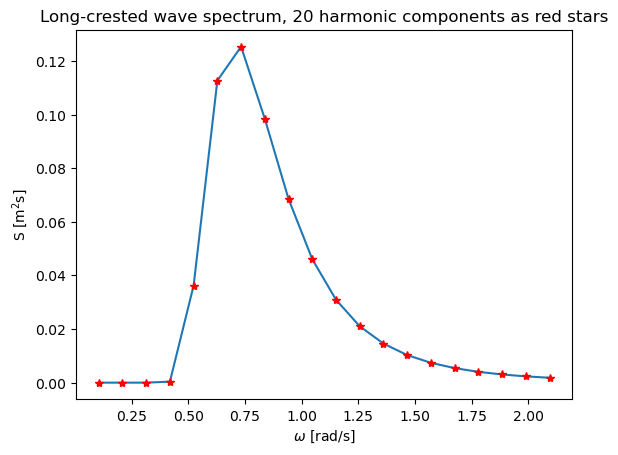

In [5]:
plt.figure()
plt.plot(omega_vec, s_omega)
plt.plot(omega_vec, s_omega, 'r*')
plt.xlabel("$\omega$ [rad/s]")
plt.ylabel("S [m$^2$s]")
plt.title("Long-crested wave spectrum, "+str(nfreq)+" harmonic components as red stars")

You can try using different number of harmonic components and check the simulation time.

Now we need to calculate the wave amplitude and wave number for every harmonic component.

In [6]:
from scipy.optimize import root_scalar
zeta_a = []
wavenum = []
for ii in np.arange(0, nfreq):
    # Calculate the wave amplitude.
    # The area under the spectrum represents 0.5*zeta_a^2
    # here we assume that this area is simply calculated by the S(w)*Deltaw.
    zeta_a.append(np.sqrt(2*s_omega[ii]*delta_omega))

    # Calculate the wave numbers using the dispersion relation
    # we are going to use the root_scaler function to solve the non-
    # linear equation
    wavenum_0 = omega_vec[ii]**2/g
    def func(k):
        return k*np.tanh(k*depth) - omega_vec[ii]**2/g
    sol = root_scalar(func, method='toms748', bracket=[wavenum_0, 1e10])
    wavenum.append(sol.root)
omega = omega_vec

Now we have defined all our required parameters!

## Part 2: Create time domain simulation of wave eleveation

List of time values for simulation
Note: depending on number of frequency components (`nfreq`), the time response will be repeated after $2\pi/$`delta_omega`

In [7]:
t = np.arange(0, 100.1, 0.1)

# Define position
x = 0.0

For each time step the wave elevation is obtained as the superpostiion of the different harmonic components. Please note that it can be done in a vectorial way for all frequencies and is not necessary to use a for loop.

Text(0, 0.5, 'Surface elevation $zeta$ [m]')

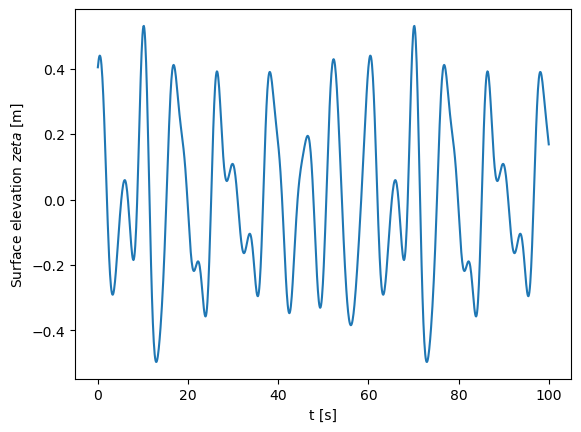

In [8]:
zeta = []
for i in np.arange(0, len(t)):
    zeta.append(np.sum(zeta_a*np.cos(omega*t[i] + phase - np.array(wavenum)*x)))

plt.figure()
plt.plot(t, zeta)
plt.xlabel("t [s]")
plt.ylabel("Surface elevation $zeta$ [m]")

For the rest of this assignment you will also need to calculate the hydrodynamics for time domain simulations. You will need to make use of potential theory to calculate velocites and accelerations at the required positions. At this point, this step should be straightforward since the wave parameters for the different harmonic components are already calculated in this tutorial. 

Note that the position, where the velocites and accelerations are required, change according to the motion of the structure. Also note that the time step of calculation will be given by the ode solver and is not predefined as we did in this example. 

In [9]:
# Implement here ...